In [187]:
# Blueprint of the class VAR 
#requirements: 
import pandas as pd
import numpy as np
import logging 
from core.analysis_base_class import Analysis
from analysis import timeline_analysis as ta
from statsmodels.tsa.api import VAR as var 
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.tsatools import detrend
from matplotlib import pyplot
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import grangercausalitytests

logger = logging.getLogger(__name__)


class VAR(Analysis):
    """ When creating var model we first generate a timeline in the form of pandas df. Then feed it to VAR method in statsmodels.
        We can save the names of the variables(queries) this way so no need of mapping (var to name) on the later stages,
        awesome plotting functionality and just comfortable to work with for everyone. 
    """
     
    def __init__(self):  
        """creates variables: 
            @self.flag_stationarity = boolean of whether assumptions checks for VAR were run ## delete?!
        """
        
        self.flag_stationarity = False
        logger.warning("just  init some varaibles")    ##
        
    
    def fit(self,queries,timefield,granularity,querytype="count",nlags=None, **kwargs):
        """ @queries  = what do you want to query from ES ? eg queries = ['de','het']
            @timefield = what field do you want to use to get the dates/timeline from ? 'META.ADDED'
            @granularity = 'day'/'week'/'month' etc 
            @nlags -  number of lags to consider, if none - rely on statsmodels to choose lag for you
            
            Possible kwargs to be added later: 
                @do_assump_check = True/False
                @do_transfomations = True/False
                @max_order_diff = maximum order of differencing 
                @max_order_detrend = maximum order of detredning
        """
        timeline = ta.timeline_generator()
        df_raw = timeline.analyse(queries=queries,timefield = timefield, granularity = granularity)
        df_raw.index = df_raw.timestamp
        df_raw = df_raw.drop('timestamp',axis=1) 
        self.df_raw = df_raw
        ##self.model = var(self.df)     ## this makes a VAR model
        ## df = self.df  ## current dataframe that you are working with
    
        logger.warning("Before fitting, I automatically do assumptions' checks and modification to the model") 
        self.max_order_diff = 2
        self.max_order_detrend = 2
        
        self.check_1 = self.test_assumptions(df_raw,level='1%')  # what should test assump return?   
        self.check_2 = 0.0          # run check on autocorrelations of the residuals 
        
        
        self.model = var(self.df)
        self.result = self.model.fit(nlags) 
        
        return ##

    def test_assumptions(self,df,level = '5%', **kwargs):
        """ 
        Gives you output as list with assumptions stated as satisfied/not satisfied. If some important 
        assumptions are not satisfied gives you warning that you have to transform your data. 
        
        @df - 'active' df which we might wnat to modify
        @level -  this is the level you are testing your asusmptions on (either 1,5 or 10 %)
        """
        self.level =  level
        
        def _adf_test(df):
            """ 
            H_0: the observed time series is stationary 
            Returns: dataframe of summary of the test 
            """
            summary_adf = pd.DataFrame(columns=['ADF_Stat','p-value','Critical_val_1%','Critical_val_5%','Critical_val_10%'])
            for name in df.columns:
                series = df[name]
                result = adfuller(series)
                dic = {'ADF_Stat':result[0],'p-value':result[1],'Critical_val_1%':result[4]['1%'],'Critical_val_5%':result[4]['5%'],
                       'Critical_val_10%':result[4]['10%']}
                summary_adf = summary_adf.append(dic,ignore_index=True)
            summary_adf.set_index(df.columns,inplace=True)  

            return summary_adf 
    
        
        def _stationary(df, explicit=True):
            """ 
            For each time series return the result of the check - return in created dataframe ?
            """
            lvl = float(self.level[:-1])/100 
            self.summary_adf = _adf_test(df)
            stat_flag = True       ## if test failed, we assume we need to take action 
            if explicit:
                for i in df.columns:
                    adf_flag = lvl > self.summary_adf.loc[i,'p-value']
                    if (adf_flag == False):
                        stat_flag = False 
                    print("For {} stationarity is satisfied: ADF - {}".format(i,adf_flag)) ## PRINT (!)
                    
            return stat_flag 
        
        def differencing(df, order=1):
            """ If there is no stationarity: try differencing
            """  
            helped = False   ## boolean check if differencing helped 
            def _perform_differencing():
            # Perform differencing:  
                df_diff = pd.DataFrame(columns=df.columns)
                for name in df.columns:
                    series = df[name]
                    series = series.diff(order)
                    df_diff[name] = series.dropna(axis=0)
                
                return _stationary(df_diff),df_diff   
            
            stat_check_after_diff, df_diff = _perform_differencing()
            print('Differencing helped?')   ##            
            print(stat_check_after_diff)   ##
            
            ## if differencing helped update self.df => self.df = df_diff 
            if stat_check_after_diff == True: 
                self.df = df_diff       ## CREATING FINAL DF for the first time if differncing helped
                helped = True   
                
            return helped
        
        def detrending(df, order=1):
            """ If there is no stationarity: differencing did not help - detrend
            
                (!) does not work nicely with time series where there is a lot of zeros and high volatility :(
            """     
            helped = False  ## boolean check if detrending helped
            def _perform_detrending():
            # Perform detrending:  
                df_res = pd.DataFrame(columns=df.columns)
                for name in df.columns:
                    series = df[name]
                    res = detrend(series,order)
                    df_res[name] = series.dropna(axis=0)
                
                return _stationary(df_res), df_res  
            
            stat_check_after_detrend,df_detrended = _perform_detrending()
            print('Detrending helped?')       ##            
            print(stat_check_after_detrend)   ##
            
            ## if detrending helped update self.df => self.df = df_diff 
            if stat_check_after_detrend == True: 
                self.df = df_detrended             ## CREATING FINAL DF for the first time if detrending helped
                helped = True   
            
            return helped
        
        
        self.flag_stationarity = _stationary(df,explicit=False)
        
        #self.flag_stationarity  = False                       ##Delete, just for testing ##
        
        if self.flag_stationarity == True: 
            self.df = self.df_raw               # if no transoformation needed - just use df_raw
            print('No need in transforms as stationarity is {}'.format(self.flag_stationarity)) ##
        else: 
            # (1) start the iterative procedure of differencing
            for i in range(1,self.max_order_diff + 1):
                diff_helped = differencing(df,order=i)
                if diff_helped == True:
                    #print(self.df)
                    self.flag_stationarity = diff_helped 
                    break 
            # (2) if differencing did not help do detrending 
            
            #self.flag_stationarity  = False                    ##Delete, just for testing ##
            
            if self.flag_stationarity == False: 
                for i in range(1,self.max_order_detrend + 1):
                    detrend_helped = detrending(df,order=i)
                    if detrend_helped == True:
                        #print(self.df)
                        self.flag_stationarity = detrend_helped 
                        break
        
        return #
    
    def diagnostics(self,level,**kwarg):
        """ Possible diagnostics: 1. serial/autocorrelation of the residuals check via Ljung_Box test
            2.residual acf plot
            
            @level = what confidence level to use in test Ljung_Box 
            Possible kwargs to be added later:
                @do_plot = boolean, show the acf plot of the residuals
        """
        residuals = self.result.resid      # making a copy 
        self.lag = 2                                       ##### THIS VARAIBLE NEEDS TO BE CREATED !!!
        
        def _ljbox_test():
            """H_0: the data are independently distributed, not enough evidence to supoprt serial corr
            Returns: dataframe of summary of the test 
            """
            summary_ljb = pd.DataFrame(columns=['ljbvalue','p-value'])
            for name in self.df.columns:
                series = residuals[name]
                result = acorr_ljungbox(series,lags=self.lag)
                dic = {'ljbvalue':result[0][self.lag-1],'p-value':result[1][self.lag-1]}
                summary_ljb = summary_ljb.append(dic,ignore_index=True)
            self.summary_ljb = summary_ljb.set_index(self.df.columns) 
            
            lvl = float(level[:-1])/100
            res_white_flag = True                ## if test failed, we assume we need to take action 
            for i in self.df.columns:
                not_white = lvl > self.summary_ljb.loc[i,'p-value']
                if (not_white == True):
                    res_white_flag = False 

            return res_white_flag
        
        def _plot_res_acf(): 
            """
            """
            for name in self.df.columns:
                series = residuals[name]
                print("Residuals autocorelation plot for {}".format(name))
                plot_acf(series, lags=self.lag)
                pyplot.show()
            return # _plot_res_act 
        
        
        res_check = _ljbox_test()
        _plot_res_acf()           
        
        
        return res_check # for diag 
        
       
        
    def granger(self,ts_1,ts_2,level,lag):
        """The Null hypothesis for grangercausalitytests is that the time series in the second column,
            x2, does NOT Granger cause the time series in the first column, x1.
            
            @ts_1 - time series which is assumed to not granger cause ts_2 (regressor)
            @ts_2 - time series which is assumed to be not granger cause ts_1 
            @level - confidence level of ssr f test 
            @lag - lag at which we want the test
        """
        array = self.df.iloc[:,[ts_2-1,ts_1-1]].values
        
        #Granger causality table for the last call of self.granger()
        table = grangercausalitytests(array,maxlag=lag,verbose=False)[lag][0]
        self.granger_table = pd.DataFrame.from_dict(table,orient='index')
        old_names = list(self.granger_table.columns)
        new_names = ['F-val', 'p-val', 'df_denom', 'df_num']
        self.granger_table.rename(columns=dict(zip(old_names, new_names)), inplace=True)
        
        result = grangercausalitytests(array,maxlag=lag,verbose=False)[lag][0]['ssr_ftest']
        
        granger_flag = result[1] < float(level[:-1])/100          
       
        
        return granger_flag # for granger 
        
        
        
        
     










In [116]:
import inca 
from statsmodels.tsa.stattools import q_stat
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox

In [188]:
m1 = VAR()

In [189]:
m_fit = m1.fit(queries=['d','h','y'], timefield = 'META.ADDED', granularity = 'day')

No need in transforms as stationarity is True


In [191]:
m1.granger(ts_1=1,ts_2=2,level='5%',lag=2)
#m1.granger_table
#grangercausalitytests(m1.df.iloc[:,0:1],maxlag=2)

False

In [86]:
#m1.diagnostics
#m1.diagnostics('1%')
#m1.summary_ljb

In [141]:
m1.result.resid.iloc[:,1].values

array([  1.40503172e+01,  -7.39490377e+00,  -2.23277067e+00,
         2.17672293e+01,   0.00000000e+00,   1.76722933e+00,
        -4.27435864e-15,  -2.23277067e+00,  -2.23277067e+00,
        -2.23277067e+00,  -2.23277067e+00,  -2.23277067e+00,
        -2.23277067e+00,  -2.23277067e+00,  -2.23277067e+00,
        -2.23277067e+00,  -2.23277067e+00,  -2.23277067e+00,
        -2.23277067e+00,  -2.23277067e+00,  -2.23277067e+00,
        -2.23277067e+00,  -2.23277067e+00,   7.76722933e+00])

In [101]:
m1.result.resid_corr

array([[ 1.        ,  0.82367053,  0.85961797],
       [ 0.82367053,  1.        ,  0.9895712 ],
       [ 0.85961797,  0.9895712 ,  1.        ]])

In [100]:
m1.result.resid_acorr()

array([[[ 1.        ,  0.82367053,  0.85961797],
        [ 0.82367053,  1.        ,  0.9895712 ],
        [ 0.85961797,  0.9895712 ,  1.        ]],

       [[-0.00690914, -0.01077653, -0.00981867],
        [-0.00599101, -0.0898677 , -0.08370556],
        [-0.01248548, -0.09301561, -0.08641538]]])

In [176]:
acorr_ljungbox(m1.result.resid.iloc[:,0],lags=2,boxpierce=False)

#q_stat(acf(m1.result.resid.iloc[:,1]),nobs=len(m1.result.resid.iloc[:,1]))

(array([ 0.0012951 ,  0.01535185]), array([ 0.9712923 ,  0.99235346]))

In [86]:
m1.result.test_normality()
pyplot.show()

Normality skew/kurtosis Chi^2-test
   Test statistic   Critical Value          p-value  df
-------------------------------------------------------
       258.496368         9.487729            0.000   4
H_0: data generated by normally-distributed process
Conclusion: reject H_0 at 5.00% significance level


In [98]:
#m1.diagnostics()

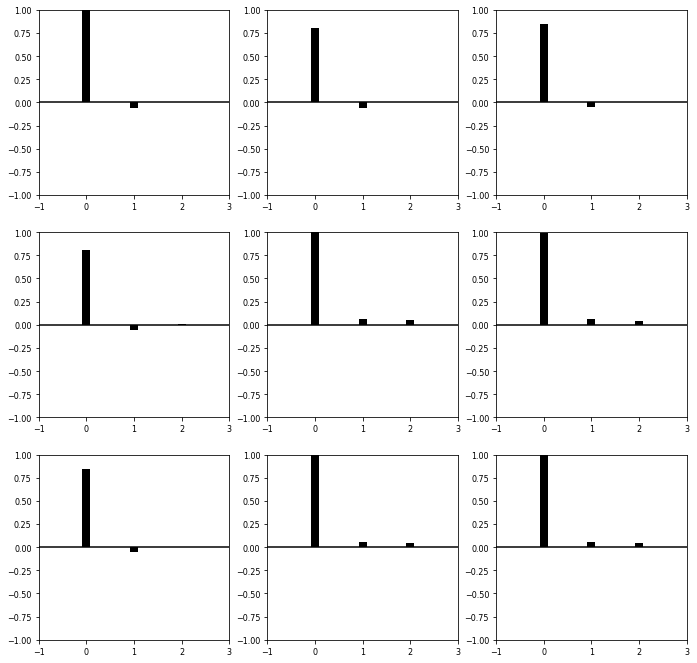

In [57]:
m1.result.resid
autocor = m1.result.acorr() #theoretical autocorrelation function
#print(autocor)
m1.result.plot_acorr(2)
pyplot.show()   

In [ ]:
def _kpss_test(df):
            """ 
            H_0: there is a unit root in time series, hence stochastic trend with drift, hence non-stationary
            Returns: dataframe of summary of the test
            """
            summary_kpss = pd.DataFrame(columns=['KPSS_Stat','p-value','Critical_val_1%','Critical_val_5%','Critical_val_10%'])
            for name in df.columns:
                series = df[name]
                result = kpss(series)
                dic = {'KPSS_Stat':result[0],'p-value':result[1],'Critical_val_1%':result[3]['1%'],'Critical_val_5%':result[3]['5%'],
                       'Critical_val_10%':result[3]['10%']}
                summary_kpss = summary_kpss.append(dic,ignore_index=True)
            summary_kpss.set_index(df.columns,inplace=True)  

            return summary_kpss